# Environment Setup

Install requirements

In [ ]:
!pip install datasets
!pip install transformers datasets torch
!pip install evaluate accelerate transformers[torch] -U
!pip install accelerate -U
!pip install kaggle

Import essential libraries

In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np

Important variables for reproducibility

In [3]:
# We will use this seed for all random functions to ensure that they are deterministic and reproducable
RANDOM_SEED = 3109

# Data Setup

Import Dataset from Kaggle

In [4]:
from google.colab import files
!pip install -q kaggle
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d rounakbanik/the-movies-dataset
!ls
!mkdir data
!unzip the-movies-dataset.zip -d data

Saving kaggle.json to kaggle.json
100% 228M/228M [00:01<00:00, 210MB/s]
100% 228M/228M [00:01<00:00, 189MB/s]
kaggle.json  sample_data  the-movies-dataset.zip
Archive:  the-movies-dataset.zip
  inflating: data/credits.csv        
  inflating: data/keywords.csv       
  inflating: data/links.csv          
  inflating: data/links_small.csv    
  inflating: data/movies_metadata.csv  
  inflating: data/ratings.csv        
  inflating: data/ratings_small.csv  


# Data Integration

Create a new CSV with 'genres' from movies_metadata.csv and 'keywords' from keywords.csv, joined together on 'id'

In [52]:
# Read in 'movies_metadata' and 'keywords'
df1 = pd.read_csv('data/movies_metadata.csv' , low_memory=False)
df2 = pd.read_csv('data/keywords.csv' , low_memory=False)

# Convert the 'id' columns to strings
df1['id'] = df1['id'].astype(str)
df2['id'] = df2['id'].astype(str)

# Merge the csv files on 'id' matching
merged_df = pd.merge(df1, df2, on='id')
# Select only the 'genres' and 'keywords' columns of the newly merged csv
merged_df = merged_df.loc[:,['genres', 'keywords']]

Convert the dictionary contents of both 'genres' and 'keywords' columns into tuples

In [53]:
evaluated_df = merged_df

# Apply 'literal_eval' from ast library to each entry (converting string representation of dictionaries into python dictionaries)
evaluated_df['genres'] = evaluated_df['genres'].apply(ast.literal_eval)
evaluated_df['keywords'] = evaluated_df['keywords'].apply(ast.literal_eval)

# We are only interested in the 'names' of keywords and genres
def extract_names(dict_list):
    return [d['name'] for d in dict_list if 'name' in d]

# Extract the 'name' values of the evaluated dictionaries
evaluated_df['genres'] = evaluated_df['genres'].apply(extract_names)
evaluated_df['keywords'] = evaluated_df['keywords'].apply(extract_names)

# Convert the extracted 'name' lists into tuples (tuples work much better with Pandas dataframe functions)
evaluated_df['genres'] = evaluated_df['genres'].apply(tuple)
evaluated_df['keywords'] = evaluated_df['keywords'].apply(tuple)


In [54]:
# After data selection, the final step should be the 'df' (what the next sections will work with)
df = evaluated_df

# Data Cleaning

Filter out rows with missing values

In [55]:
no_empty_df = df.copy()

In [56]:
# Set 'no_empty_df' to be 'no_empty_df' where the 'genres' in each row has more than 0 list items
no_empty_df = no_empty_df[no_empty_df['genres'].apply(lambda x: len(x) > 0)]

# Set 'no_empty_df' to be 'no_empty_df' where the 'keywords' in each row has more than 0 list items
no_empty_df = no_empty_df[no_empty_df['keywords'].apply(lambda x: len(x) > 0)]

In [57]:
# Calculate how many rows were "lost"
before = len(df)
after = len(no_empty_df)

print((before - after), 'rows with missing values removed')

15199 rows with missing values removed


In [58]:
display(no_empty_df)

genres  \
0       (Animation, Comedy, Family)   
1      (Adventure, Fantasy, Family)   
2                 (Romance, Comedy)   
3          (Comedy, Drama, Romance)   
4                         (Comedy,)   
...                             ...   
46472   (Horror, Mystery, Thriller)   
46473             (Mystery, Horror)   
46474                     (Horror,)   
46477               (Drama, Family)   
46478                      (Drama,)   

                                                keywords  
0      (jealousy, toy, boy, friendship, friends, riva...  
1      (board game, disappearance, based on children'...  
2      (fishing, best friend, duringcreditsstinger, o...  
3      (based on novel, interracial relationship, sin...  
4      (baby, midlife crisis, confidence, aging, daug...  
...                                                  ...  
46472  (revenge, murder, serial killer, new york city...  
46473                                     (blair witch,)  
46474  (witch, mythology, legend, serial killer, mock...  
46477                                     (tragic love,)  
46478                              (artist, play, pinoy)  

[31283 rows x 2 columns]

Remove duplicate entries from the DataFrame

In [59]:
no_dupe_df = no_empty_df.drop_duplicates(keep='first')

In [60]:
print(no_dupe_df)

                             genres  \
0       (Animation, Comedy, Family)   
1      (Adventure, Fantasy, Family)   
2                 (Romance, Comedy)   
3          (Comedy, Drama, Romance)   
4                         (Comedy,)   
...                             ...   
46472   (Horror, Mystery, Thriller)   
46473             (Mystery, Horror)   
46474                     (Horror,)   
46477               (Drama, Family)   
46478                      (Drama,)   

                                                keywords  
0      (jealousy, toy, boy, friendship, friends, riva...  
1      (board game, disappearance, based on children'...  
2      (fishing, best friend, duringcreditsstinger, o...  
3      (based on novel, interracial relationship, sin...  
4      (baby, midlife crisis, confidence, aging, daug...  
...                                                  ...  
46472  (revenge, murder, serial killer, new york city...  
46473                                     (blair witch,)  


In [61]:
df = no_dupe_df

# Data Balancing

In [62]:
category_analysis = df.copy()
category_analysis['genre_lengths'] = category_analysis['genres'].apply(len)

display(category_analysis)

genres  \
0       (Animation, Comedy, Family)   
1      (Adventure, Fantasy, Family)   
2                 (Romance, Comedy)   
3          (Comedy, Drama, Romance)   
4                         (Comedy,)   
...                             ...   
46472   (Horror, Mystery, Thriller)   
46473             (Mystery, Horror)   
46474                     (Horror,)   
46477               (Drama, Family)   
46478                      (Drama,)   

                                                keywords  genre_lengths  
0      (jealousy, toy, boy, friendship, friends, riva...              3  
1      (board game, disappearance, based on children'...              3  
2      (fishing, best friend, duringcreditsstinger, o...              2  
3      (based on novel, interracial relationship, sin...              3  
4      (baby, midlife crisis, confidence, aging, daug...              1  
...                                                  ...            ...  
46472  (revenge, murder, serial killer, new york city...              3  
46473                                     (blair witch,)              2  
46474  (witch, mythology, legend, serial killer, mock...              1  
46477                                     (tragic love,)              2  
46478                              (artist, play, pinoy)              1  

[28251 rows x 3 columns]

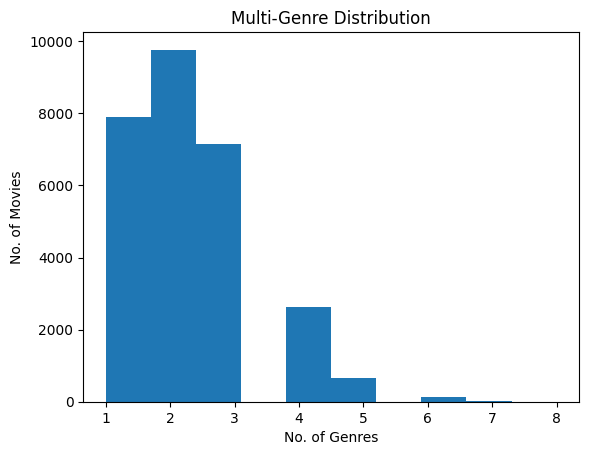

In [63]:
plt.ylabel('No. of Movies')
plt.xlabel('No. of Genres')

plt.title("Multi-Genre Distribution")
plt.hist(category_analysis['genre_lengths'], bins=10)
plt.show()

In [ ]:
combination_counts = category_analysis.groupby('genres').size()

for genres_tuple, count in combination_counts.items():
    print(f"Genres Tuple: {genres_tuple}, Count: {count}")

In [ ]:
single_category = category_analysis[category_analysis['genre_lengths'] == 1]
double_category = category_analysis[category_analysis['genre_lengths'] == 2]
triple_category = category_analysis[category_analysis['genre_lengths'] == 3]

#20 genres
single_category_stats = single_category.groupby('genres').size()
display(single_category_stats.mean())

#20 nCr 2 = 190 / actual = 160
double_category_stats = double_category.groupby('genres').size()
display(double_category_stats.describe())

#20 nCr 3 = 1140 / actual 468
triple_category_stats = triple_category.groupby('genres').size()
display(triple_category_stats.describe())

category_analysis_stats = category_analysis.groupby('genres').size()

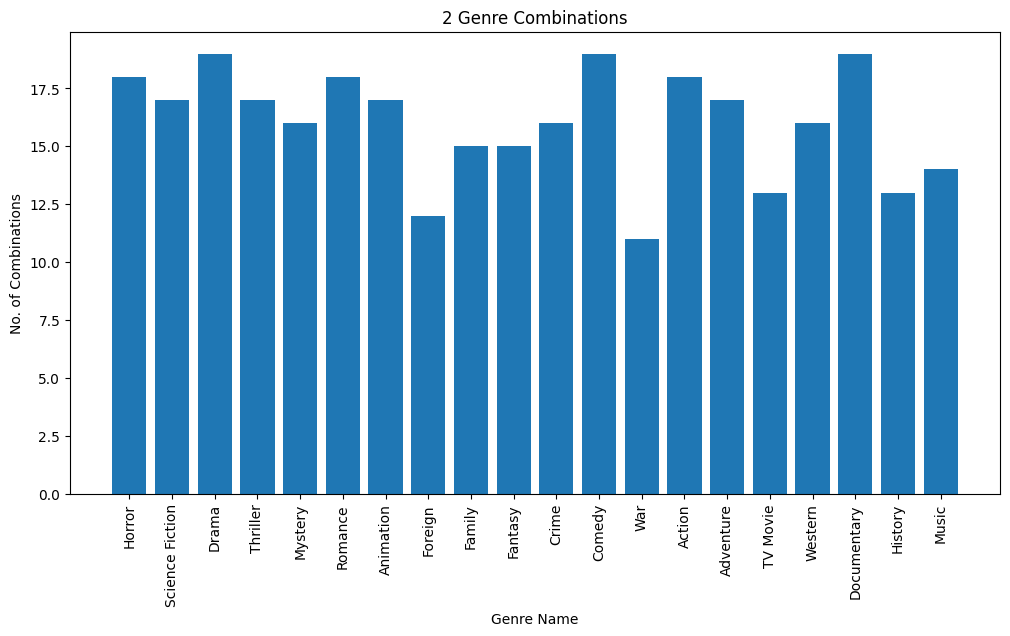

In [66]:
from collections import Counter

double_combinations = set()
unique_genres = set()

for _, row in double_category.iterrows():
    double_combinations.add(tuple(sorted(row['genres'])))
    unique_genres.update(row['genres'])

all_genres = []
for genre_tuple in double_combinations:
    all_genres.extend(genre_tuple)

genre_counts = Counter(all_genres)

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(genres, counts)

plt.title('2 Genre Combinations')
plt.xlabel('Genre Name')
plt.ylabel('No. of Combinations')

plt.xticks(rotation=90)

plt.show()

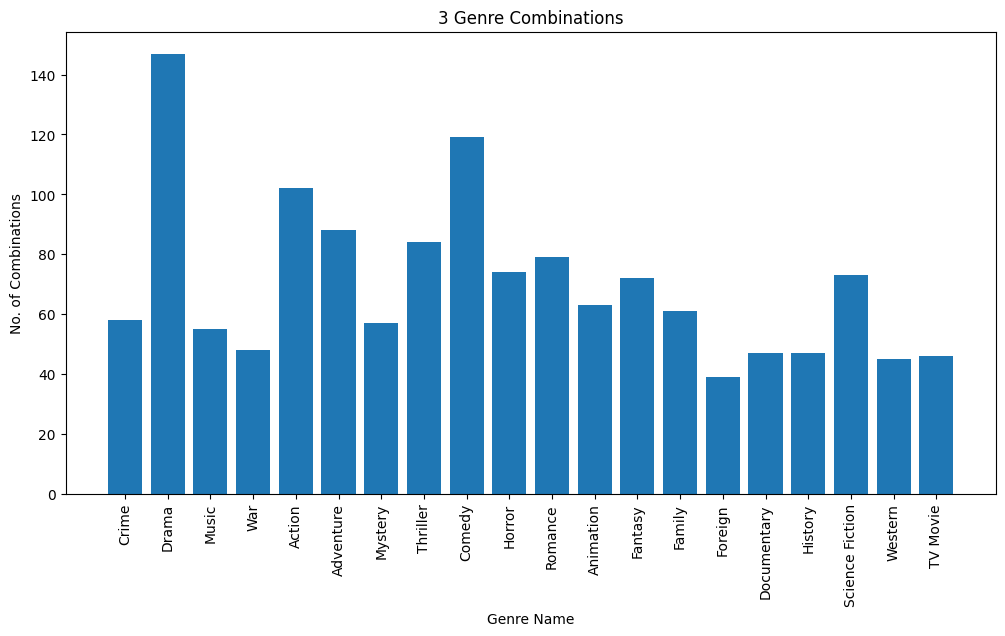

In [67]:
from collections import Counter

triple_combinations = set()
unique_genres = set()

for _, row in triple_category.iterrows():
    triple_combinations.add(tuple(sorted(row['genres'])))
    unique_genres.update(row['genres'])

all_genres = []
for genre_tuple in triple_combinations:
    all_genres.extend(genre_tuple)

genre_counts = Counter(all_genres)

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(genres, counts)

plt.title('3 Genre Combinations')
plt.xlabel('Genre Name')
plt.ylabel('No. of Combinations')

plt.xticks(rotation=90)

plt.show()

In [68]:
##balancing single genres

general_mean = single_category.groupby('genres').size()
print(general_mean)

sc_mean = int(single_category_stats.mean())

balanced_df= pd.DataFrame()

for genre in unique_genres:
  single_genre_df = single_category[single_category['genres'].apply(lambda x: genre in x)]

  count1 = len(single_genre_df)

  if count1 > sc_mean:
        # Undersample
        sampled_df = single_genre_df.sample(n=sc_mean, random_state=RANDOM_SEED)
  elif count1 < sc_mean:
        # Oversample
        sampled_df = single_genre_df.sample(n=sc_mean, replace=True, random_state=RANDOM_SEED)
  else:
        sampled_df = single_genre_df

  balanced_df = pd.concat([balanced_df, sampled_df], ignore_index=True)

genres
(Action,)              155
(Adventure,)            81
(Animation,)           111
(Comedy,)             1702
(Crime,)               101
(Documentary,)        1294
(Drama,)              2845
(Family,)               37
(Fantasy,)              42
(Foreign,)               3
(History,)               8
(Horror,)              675
(Music,)                61
(Mystery,)              46
(Romance,)              54
(Science Fiction,)     139
(TV Movie,)              3
(Thriller,)            258
(War,)                  23
(Western,)             252
dtype: int64


In [69]:
#Balancing Double-combinations

dc_mean = int(double_category_stats.mean())

for genre_combinations in double_combinations:

  double_genre_df = double_category[double_category['genres'].apply(lambda x: all(genre in x for genre in genre_combinations))]

  count = len(double_genre_df)

  if count > dc_mean:
        # Undersample
        sampled_df = double_genre_df.sample(n=dc_mean, random_state=RANDOM_SEED)
  elif count < dc_mean:
        # Oversample
        sampled_df = double_genre_df.sample(n=dc_mean, replace=True, random_state=RANDOM_SEED)
  else:
    sampled_df = double_genre_df

  balanced_df = pd.concat([balanced_df, sampled_df], ignore_index=True)

In [70]:
tc_mean = int(triple_category_stats.mean())

for genre_combinations in triple_combinations:

  triple_genre_df = triple_category[triple_category['genres'].apply(lambda x: all(genre in x for genre in genre_combinations))]

  count = len(triple_genre_df)

  if count > tc_mean:
        # Undersample
        sampled_df = triple_genre_df.sample(n=tc_mean, random_state=RANDOM_SEED)
  elif count < tc_mean:
        # Oversample
        sampled_df = triple_genre_df.sample(n=tc_mean, replace=True, random_state=RANDOM_SEED)
  else:
        sampled_df = triple_genre_df

  balanced_df = pd.concat([balanced_df, sampled_df], ignore_index=True)

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'Western'],
      dtype='object', name='genres')


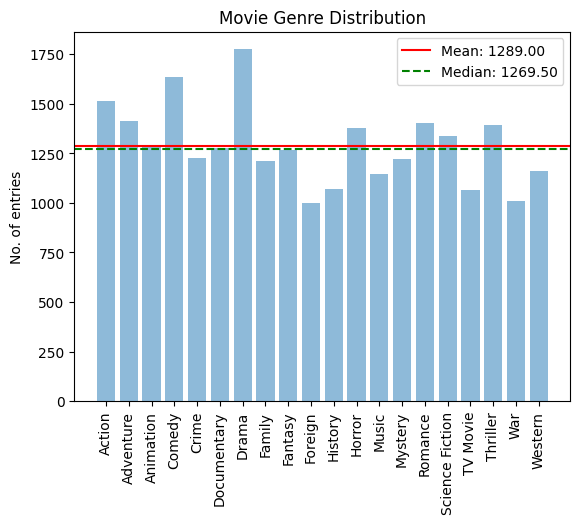

In [71]:
# Exploding the list_column
exploded_df = balanced_df.explode('genres')

# Group by the exploded column and count occurrences
grouped = exploded_df.groupby('genres').size()
print(grouped.index)

y_pos = np.arange(len(grouped))

# Calculate the mean and median (using numpy)
mean_occurrences = np.mean(grouped)
median_occurrences = np.median(grouped)

# Create the bar chart
plt.bar(y_pos, grouped, align='center', alpha=0.5)

# Adding the labels and title
plt.xticks(y_pos, grouped.index, rotation='vertical')
plt.ylabel('No. of entries')
plt.title('Movie Genre Distribution')

# Add the mean and median lines (red and green respectively)
plt.axhline(y=mean_occurrences, color='r', linestyle='-', label=f'Mean: {mean_occurrences:.2f}')
plt.axhline(y=median_occurrences, color='g', linestyle='--', label=f'Median: {median_occurrences:.2f}')

# Show illustration
plt.legend()
plt.show()

In [72]:
df = balanced_df

# Data Normalization

In [73]:
normalized_df = df.copy()

Drop the 'genre_lengths' column (used for data balancing)

In [74]:
normalized_df.drop('genre_lengths', axis=1, inplace=True)

In [75]:
import torch

In [76]:
unique_genres = set(genre for sublist in df['genres'] for genre in sublist)
unique_genres = sorted(list(unique_genres))

genre_to_index = {genre: i for i, genre in enumerate(unique_genres)}

import numpy as np

def encode_genres(genres, genre_to_index):
    encoding = np.zeros(len(genre_to_index), dtype=int)
    for genre in genres:
        encoding[genre_to_index[genre]] = 1
    return encoding

# Apply encoding to each row
normalized_df['genres'] = normalized_df['genres'].apply(lambda x: encode_genres(x, genre_to_index))


Convert the keyword tuples to text strings

In [77]:
normalized_df['keywords'] = normalized_df['keywords'].apply(lambda x: ', '.join(map(str, x)))

In [78]:
df = normalized_df

# Dataset Splitting

In [79]:
from datasets import DatasetDict, Dataset
from sklearn.model_selection import train_test_split

df['labels'] = df['genres']
df.drop('genres', axis=1, inplace=True)
dataset = Dataset.from_pandas(df)
# Split the dataset into training and testing sets
split_dataset = dataset.train_test_split(test_size=0.2, seed=RANDOM_SEED)

In [80]:
from transformers import DistilBertTokenizer


# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['keywords'], padding='max_length', truncation=True, max_length=512)

# Apply the tokenization to the dataset
tokenized_datasets = split_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/12528 [00:00<?, ? examples/s]

Map:   0%|          | 0/3132 [00:00<?, ? examples/s]

In [81]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['keywords', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 12528
    })
    test: Dataset({
        features: ['keywords', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 3132
    })
})


In [82]:
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

In [83]:
print(train_dataset)

Dataset({
    features: ['keywords', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 12528
})


# Dataset Util

In [ ]:
# Save the dataset to a csv
df.to_csv('out.csv', index=False)

In [ ]:
# View the pandas dataframe
display(df)

# Training Setup

In [ ]:
!pip install torch transformers
!pip install accelerate transformers[torch] -U

In [42]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, AdamW, DataCollatorWithPadding
from datasets import load_dataset, Dataset

We can use this to verify that Google Colab is using a GPU

In [87]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=20,  problem_type="multi_label_classification")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
print(torch.cuda.is_available())
!nvidia-smi
model = model.to('cuda')

True
Thu Jan 25 20:51:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              52W / 400W |  22163MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+--------------------

In [89]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=6,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    logging_dir='./logs',
)

In [90]:
def custom_collator(batch):
    # Use the default data collator to handle input_ids, attention_mask, etc.
    default_collator = DataCollatorWithPadding(tokenizer)
    batch = default_collator(batch)

    # Convert labels to tensors
    if 'labels' in batch:
        batch['labels'] = torch.tensor(batch['labels'], dtype=torch.float)

    return batch

In [91]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss

def compute_metrics(p):
    predictions, labels = p
    # Convert logits to 0 or 1 based on a 0.5 threshold
    predictions = (predictions > 0.5).astype(int)
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='samples')
    acc = accuracy_score(labels, predictions)
    hamming = hamming_loss(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming
    }


In [92]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=custom_collator,
    compute_metrics=compute_metrics,
)

In [93]:
display(train_dataset)

Dataset({
    features: ['keywords', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 12528
})

In [ ]:
trainer.train()

<ipython-input-90-fd42bde11394>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch['labels'] = torch.tensor(batch['labels'], dtype=torch.float)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-90-fd42bde11394>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch['labels'] = torch.tensor(batch['labels'], dtype=torch.float)


In [ ]:
results = trainer.evaluate()

<ipython-input-168-fd42bde11394>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch['labels'] = torch.tensor(batch['labels'], dtype=torch.float)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(results)

{'eval_loss': 0.11773193627595901, 'eval_accuracy': 0.6669859514687101, 'eval_f1': 0.7603630724320378, 'eval_precision': 0.7963761174968071, 'eval_recall': 0.7502128565346956, 'eval_hamming_loss': 0.03204022988505747, 'eval_runtime': 12.7661, 'eval_samples_per_second': 245.338, 'eval_steps_per_second': 7.677, 'epoch': 6.0}


In [ ]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [ ]:
!zip -r /content/model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/config.json (deflated 62%)
  adding: content/saved_model/vocab.txt (deflated 53%)
  adding: content/saved_model/model.safetensors (deflated 8%)
  adding: content/saved_model/tokenizer_config.json (deflated 76%)
  adding: content/saved_model/tokenizer.json (deflated 71%)
  adding: content/saved_model/special_tokens_map.json (deflated 42%)
